In [46]:
import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.rijke_galerkin.solver import Rijke
from adjoint_esn.utils import preprocessing as pp
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import errors,scalers
from adjoint_esn.validation import validate
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils.enums import eParam, get_eVar
from pathlib import Path
from adjoint_esn.rijke_galerkin import sensitivity as sens
import adjoint_esn.utils.postprocessing as post

## Generate data

In [29]:
np.random.seed(seed=41)

# number of galerkin modes
N_g = 4

# simulation options
sim_time = 500
sim_dt = 1e-3
# network time step
network_dt = 1e-2

# directory to search for simulation data, 
# if the data doesn't exist, then it will simulate the system
# since this may take time each time, it might be better to simulate the regimes used for training 
# and save them using the script "generate_rijke_data.py"
data_dir=Path('data')

# which regimes to use for training and validation
INIT_beta_list = np.arange(1.0,6.0,1.0)
INIT_tau_list = np.arange(0.1,0.35,0.05)
param_list = pp.make_param_mesh([INIT_beta_list,INIT_tau_list])

# we will split the dataset into train and validation regimes
n_train_regimes = 20
n_val_regimes = 5
shuffled_idx_list = np.random.choice(len(param_list), size=n_train_regimes+n_val_regimes, replace=False)
train_idx_list =  shuffled_idx_list[:n_train_regimes] # indices of regimes used for training
val_idx_list = shuffled_idx_list[n_train_regimes:] # indices of regimes used for validation

# times
transient_time = 200
N_transient = pp.get_steps(transient_time, network_dt)

washout_time = 4
N_washout = pp.get_steps(washout_time, network_dt)

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
# these enums help referring to the state variables instead of indexing
input_vars ='eta_mu_v_tau'
eInputVar = get_eVar(input_vars,N_g) 
output_vars ='eta_mu'
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=['beta']

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = 1

# length of training time series
train_time = 8
# length of validation time series
validation_time = 200
# can add test, then add it in the loop_names and loop_times
test_time = 10

# noise level added to the data
noise_level = 0 # in percentage wrt to the std of input time series

In [30]:
loop_names=['train','val']
loop_times = [train_time,validation_time]

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        noise_level=noise_level,
                        random_seed=None, # set random seed for reproducibility if necessary
                        tau=p_sim["tau"])
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

### Plot data
Plot some of the training and validation regimes

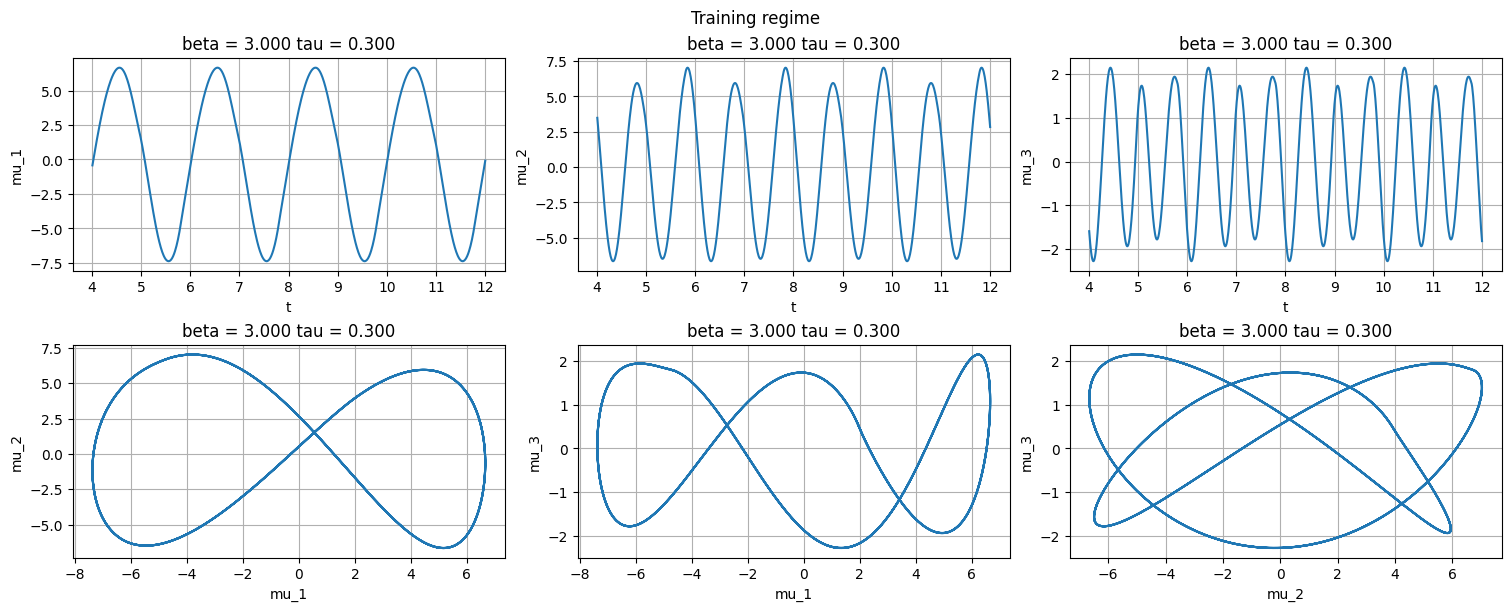

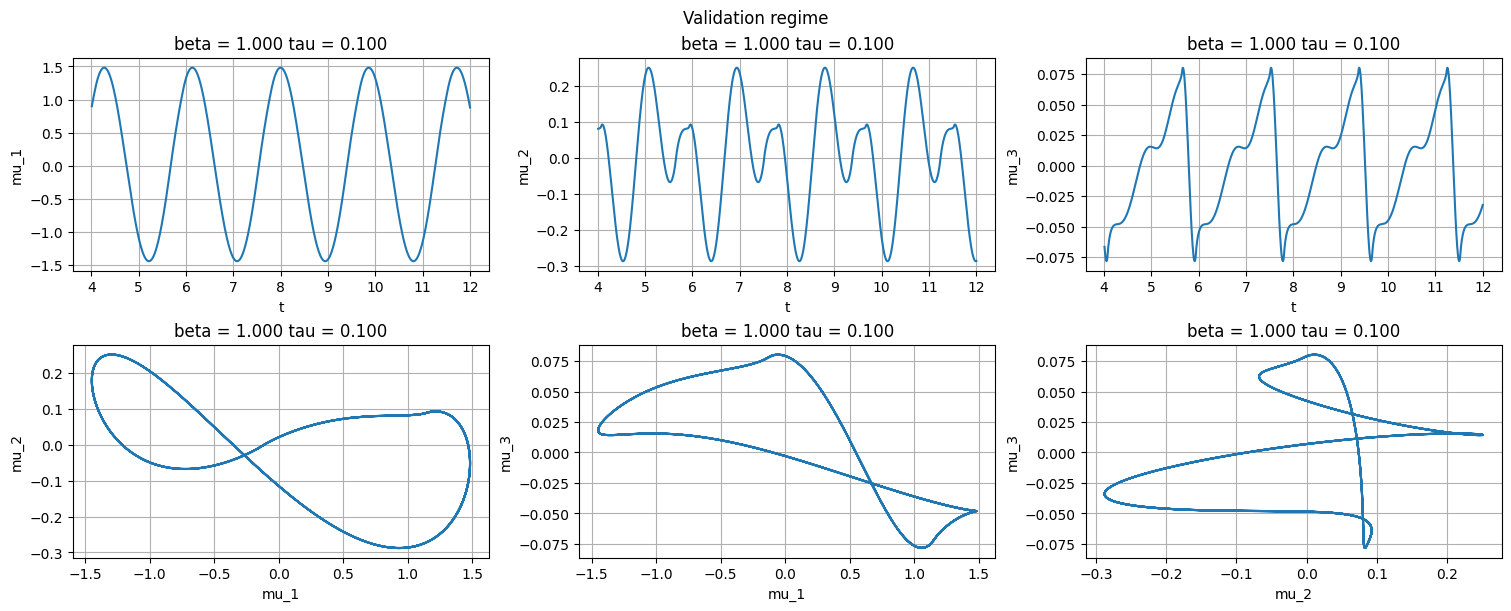

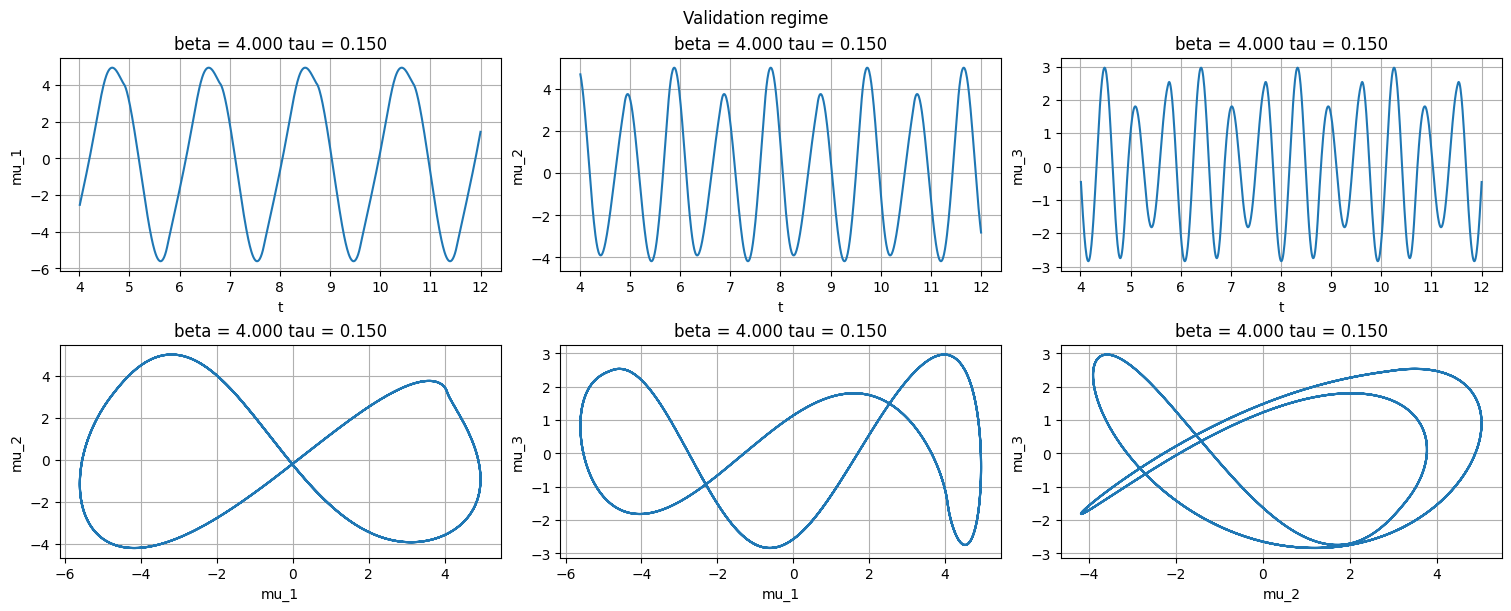

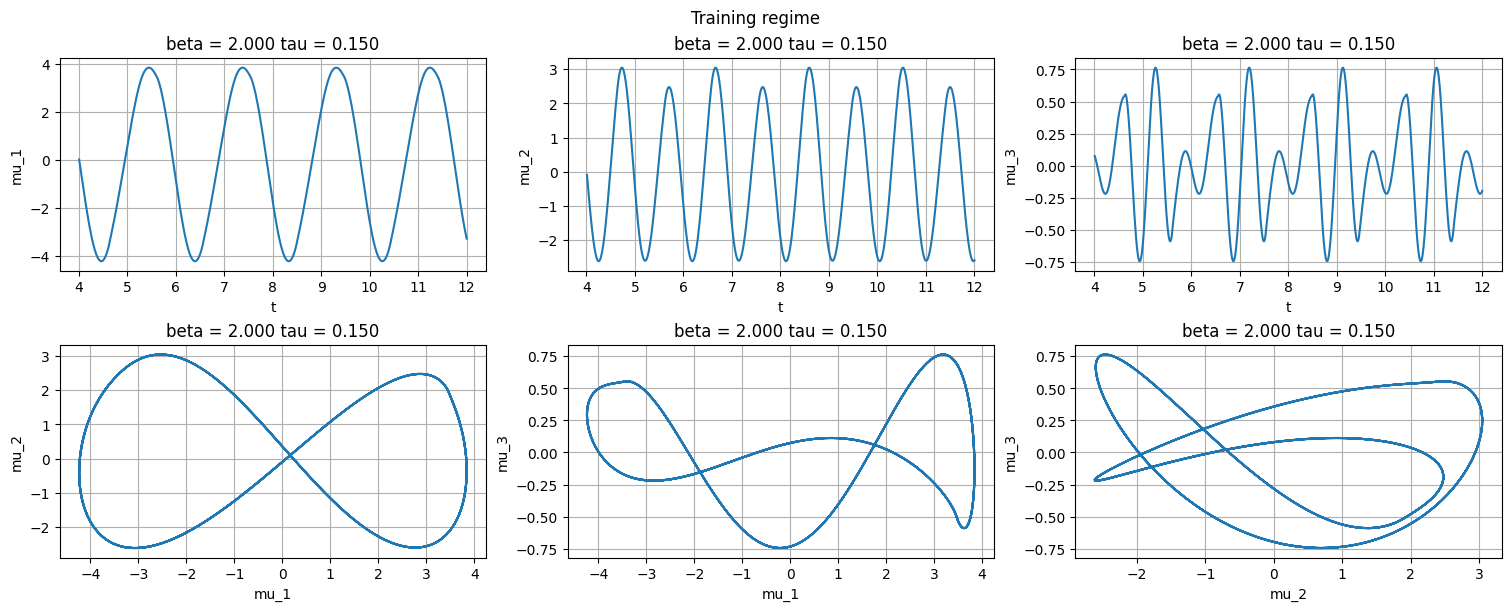

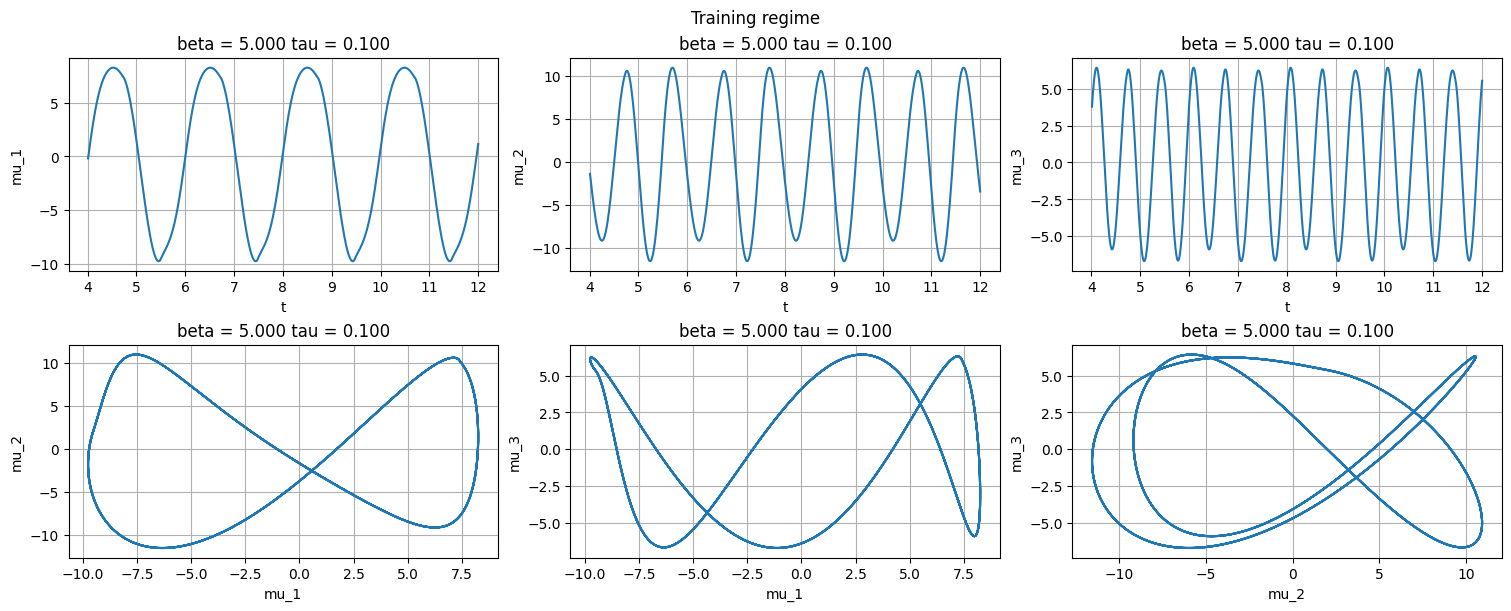

In [31]:
plt_idx = [eOutputVar.mu_1,eOutputVar.mu_2,eOutputVar.mu_3]
plt_idx_pairs = [[eOutputVar.mu_1,eOutputVar.mu_2],
                 [eOutputVar.mu_1,eOutputVar.mu_3],
                 [eOutputVar.mu_2,eOutputVar.mu_3]]
plt_p_idxs = np.random.choice(len(param_list), size=5, replace=False) 
for p_idx in plt_p_idxs:
    p = param_list[p_idx]
    plt.figure(figsize = (15,6),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(2,len(plt_idx),j+1)
        title_str = ' '.join([f"{param.name} = {p[param]:0.3f}" for param in eParam])
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["y"][p_idx][:,k],
                   title=title_str,
                   xlabel='t',
                   ylabel=k.name)
    if p_idx in train_idx_list:
        plt.suptitle('Training regime')
    elif p_idx in val_idx_list:
        plt.suptitle('Validation regime')

    for j, k in enumerate(plt_idx_pairs):
        plt.subplot(2,len(plt_idx),len(plt_idx)+j+1)
        vis.plot_phase_space(DATA["train"]["y"][p_idx],
                            idx_pair=k,
                            title=title_str,
                            xlabel=k[0].name,
                            ylabel=k[1].name)

# Create and train a Thermoacoustic ESN

In [32]:
# set attributes of the base Rijke ESN object
reservoir_size = 1200
connectivity = 20

ESN_dict = {'reservoir_size': reservoir_size,  
            'N_g' : N_g, 
            'x_f' : 0.2,
            'tau' : 0.2, # this is arbitrary, will be set later
            'dt' : network_dt,
            'u_f_order': u_f_order,
            'parameter_dimension' : len(param_vars),
            'reservoir_connectivity' : connectivity,
            'input_normalization': None, 
            'input_bias' : np.array([]),
            'output_bias' : np.array([]),
            'r2_mode': False,
            'input_weights_mode': "sparse_grouped_rijke_dense",
            'reservoir_weights_mode': "erdos_renyi1",
            'input_only_mode': False,
            'input_seeds': [0,1,2],
            'reservoir_seeds': [3,4],
            ## hyperparameters from the paper as default
            'spectral_radius': 0.0125,
            'input_scaling': 0.0790,
            'u_f_scaling': 1.051,
            'parameter_normalization': [np.array([-10]),np.array([0.1092])],
            'tikhonov': 1e-6,
            }

my_ESN = RijkeESN(**ESN_dict) # create an ESN object

do_hyperparameter_search = False

Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


## Hyperparameter search
Perform hyperparameter search. 
Need to configure number of folds, number of realisations and number of calls in the Bayesian optimization. 
(Skip this part if you want to use the hyperparameters provided above.)

In [33]:
# hyperparameter names, should match the attributes of ESN
hyp_param_names = ['input_scaling',
                   'u_f_scaling',
                   'spectral_radius',
                   'leak_factor',
                   'parameter_normalization_mean',
                   'parameter_normalization_var',
                   'tikhonov']

# range for hyperparameters 
spec_in     = 0.01
spec_end    = 1.0
in_scal_in  = 0.01
in_scal_end = 2.0
u_f_scal_in  = 0.01
u_f_scal_end = 2.0
leak_in     = 0.01    
leak_end    = 1.0
param_var_in = 0.01
param_var_end = 2.0
param_mean_in = -10.0
param_mean_end = 10.0
tikh_in = 1e-6
tikh_end = 1e-1
grid_range = [[in_scal_in, in_scal_end],
              [u_f_scal_in, u_f_scal_end],
              [spec_in, spec_end],
              [leak_in, leak_end],
              [param_mean_in, param_mean_end],
              [param_var_in, param_var_end],
              [tikh_in, tikh_end]]

# scales, uniform or log10
hyp_param_scales = ['log10','log10','log10','uniform','uniform','log10','log10']

# scale the ranges
for i in range(len(grid_range)):
    for j in range(2):
        scaler = getattr(scalers, hyp_param_scales[i])
        grid_range[i][j] = scaler(grid_range[i][j])
        
# set the time for each fold, i.e., trajectory, in closed-loop validation 
# we validate ESN performance in closed-loop on folds with randomly
# chosen starting points
fold_time = 4
N_val = pp.get_steps(fold_time, network_dt)

min_dict = validate(grid_range,hyp_param_names,hyp_param_scales,
    n_calls = 50, n_initial_points = 20,
    ESN_dict = ESN_dict, ESN_type = "rijke",
    U_washout_train = DATA["train"]["u_washout"],
    U_train = DATA["train"]["u"],
    U_val = DATA["val"]["u"],
    Y_train = DATA["train"]["y"],
    Y_val = DATA["val"]["y"],
    P_washout_train = DATA["train"]["p_washout"],
    P_train = DATA["train"]["p"],
    P_val = DATA["val"]["p"],
    n_folds = 3, # number of folds for validation
    n_realisations = 3, # number of different realisations of ESN
    N_washout_steps = N_washout,
    N_val_steps = N_val,
    N_transient_steps = 0,
    train_idx_list=train_idx_list,
    val_idx_list=val_idx_list,
    p_list=param_list,
    n_grid = None,
    error_measure=errors.rel_L2)

res_idx = 0 # use the hyperparameters of the top result from hyperparameter search
hyp_params = [min_dict[hyp_param_name][res_idx] for hyp_param_name in hyp_param_names]
hyp_param_scales = ['uniform']*len(hyp_param_names) # hyperparameters are saved in a uniform scale
set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)

do_hyperparameter_search = True


--NEW RUN-- 1
Realisation: 0
input_scaling 0.04869208506169775
u_f_scaling 0.13742516384006748
spectral_radius 0.07691833864717756
leak_factor 0.8335922453814891
parameter_normalization_mean 1.6664347387547274
parameter_normalization_var 0.011426702018021045
tikhonov 0.01


Val regime: 0
Val regime error: 0.12012547552861404
Val regime: 1
Val regime error: 0.2099846613706744
Val regime: 2
Val regime error: 0.07211251933511292
Val regime: 3
Val regime error: 0.2341775973660646
Val regime: 4
Val regime error: 0.22472124818620856
Realisation error: 0.17222430035733488


Realisation: 1
input_scaling 0.04869208506169775
u_f_scaling 0.13742516384006748
spectral_radius 0.07691833864717756
leak_factor 0.8335922453814891
parameter_normalization_mean 1.6664347387547274
parameter_normalization_var 0.011426702018021045
tikhonov 0.01


Val regime: 0
Val regime error: 0.12048908494268569
Val regime: 1
Val regime error: 0.21998509818990833
Val regime: 2
Val regime error: 0.06310395471934173
Val regim

In [38]:
# print new hyperparameters
print("Found optimal hyperparameters:")
for hyp_param_name, hyp_param in zip(hyp_param_names, hyp_params):
    print(f"{hyp_param_name}: {hyp_param}")

Found optimal hyperparameters:
input_scaling: 0.028911696317321323
u_f_scaling: 0.5833753890759125
spectral_radius: 0.016342620625847216
leak_factor: 0.515480931639179
parameter_normalization_mean: -5.703231942429626
parameter_normalization_var: 0.22693505977925105
tikhonov: 0.0001


## Train 

In [34]:
# train the ESN using the found hyperparameters
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

# Predict and visualize

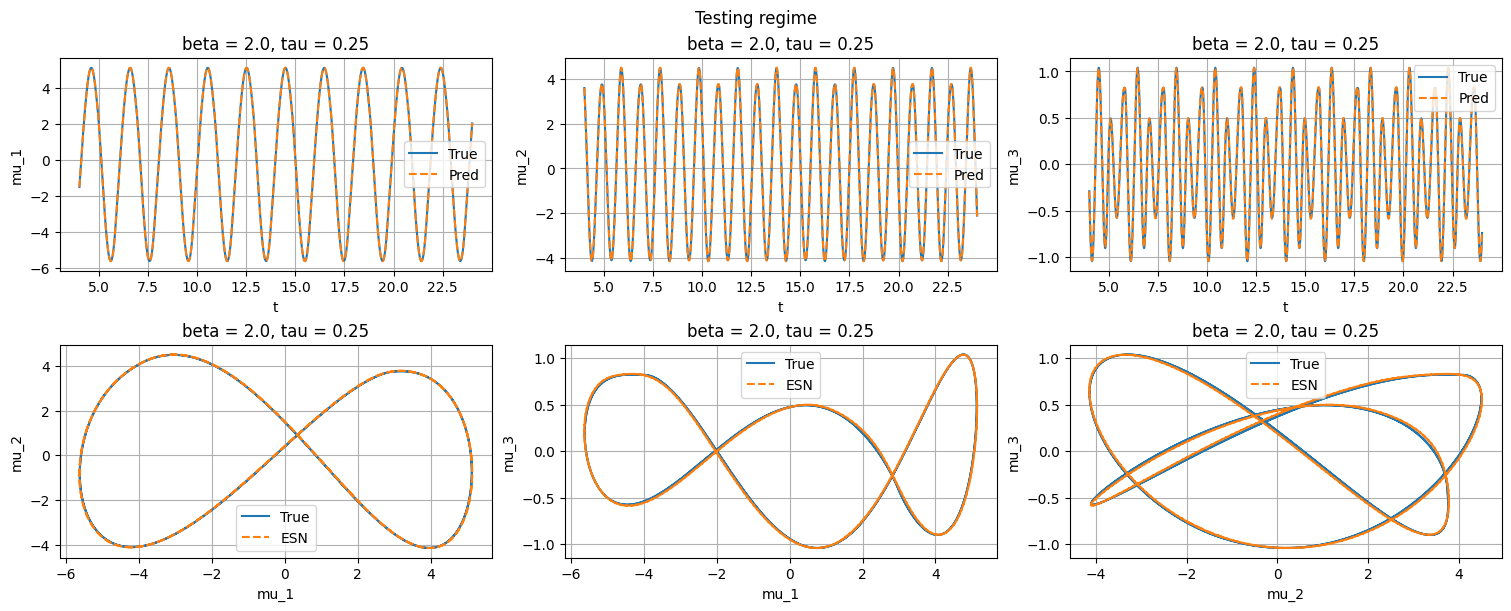

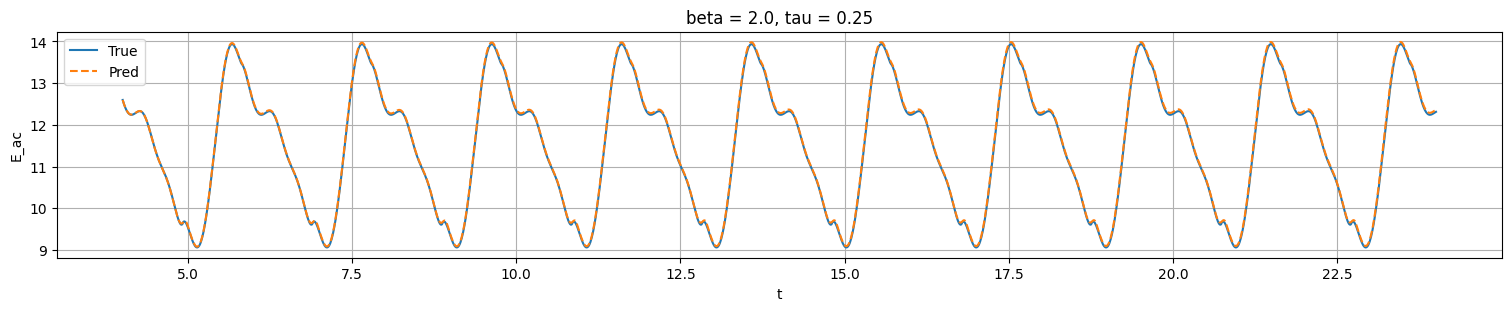

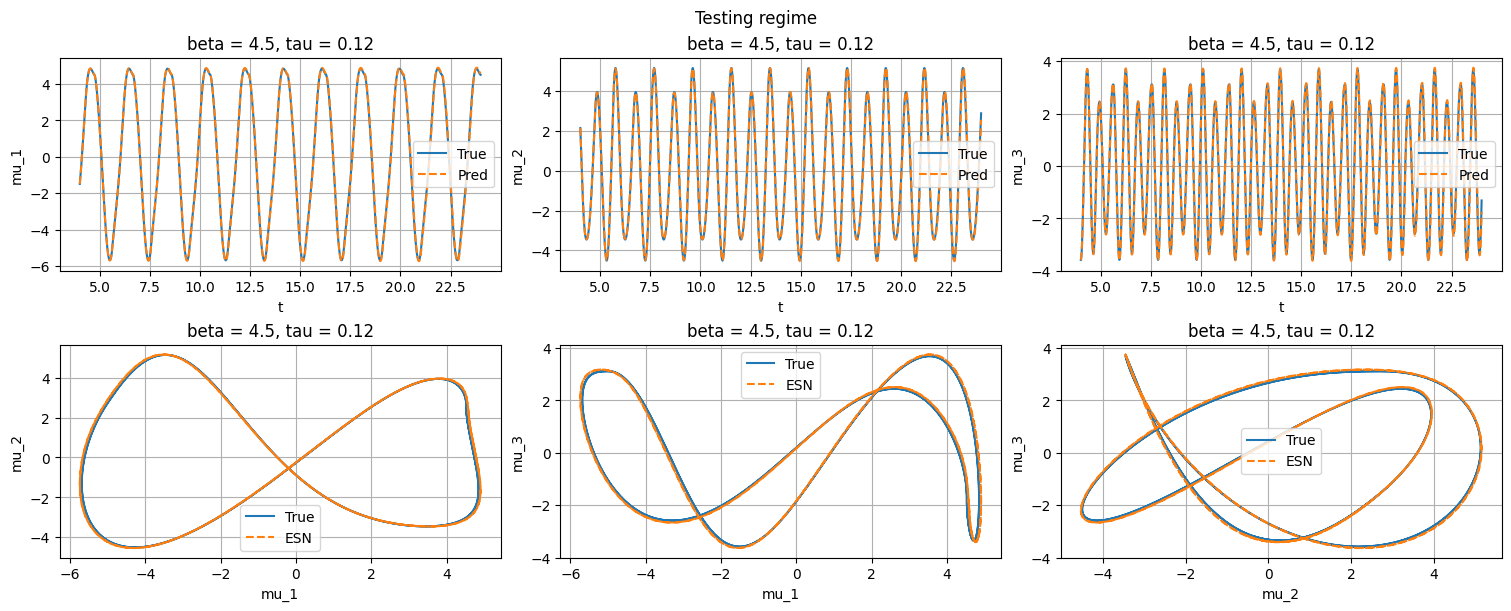

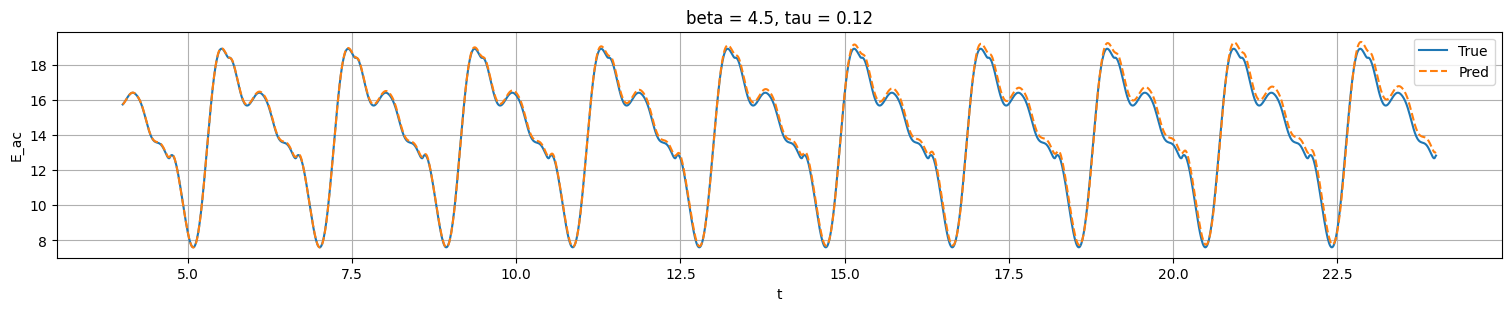

In [42]:
loop_times = [20] # can plot multiple loops (i.e., folds, trajectories)
sim_time = transient_time+np.sum(loop_times)+washout_time*len(loop_times)

# predict on some test sets not seen during training or validation
# either make a mesh like this
# param_mesh_input = [None] * 2
# param_mesh_input[eParam.beta] = [2.0]
# param_mesh_input[eParam.tau] = [0.25]

# p_list = pp.make_param_mesh(param_mesh_input) 

# or enter parameter values row by row 
# with beta being p_list[i,0] and tau being p_list[i,1] for ith row (can also use the enums as above)
p_list = np.array([[2.0,0.25],[4.5,0.12]])

plt_idx = [eOutputVar.mu_1,eOutputVar.mu_2,eOutputVar.mu_3] # plotted state variables
# pairs of state variables for phase space plot
plt_idx_pairs = [[eOutputVar.mu_1,eOutputVar.mu_2],
                 [eOutputVar.mu_1,eOutputVar.mu_3],
                 [eOutputVar.mu_2,eOutputVar.mu_3]]

phase_space_steps = pp.get_steps(4,network_dt)  # number of steps shown on the phase space plot

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        noise_level=0.0, # set noise zero for comparison to ground truth
                        random_seed=None, # set random seed for reproducibility if necessary
                        tau=p_sim["tau"])

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        regime_str = f"beta = {p_list[p_idx][eParam.beta]}, tau = {p_list[p_idx][eParam.tau]}"
        # plot time series
        plt.figure(figsize = (15,6),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(2,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='t',
                       linestyle=['-','--'],
                       legend=['True','Pred'],
                       ylabel=k.name)
            
        plt.suptitle('Testing regime')
        # plot phase space  
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(2,len(plt_idx),len(plt_idx)+ j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','ESN'],
                             xlabel=k[0].name,
                             ylabel=k[1].name)
            
        # plot acoustic energy
        J_true = sens.acoustic_energy_inst(data[loop_name]["y"], N_g)
        J_pred = sens.acoustic_energy_inst(y_pred, N_g)
        plt.figure(figsize = (15,3),constrained_layout=True)
        vis.plot_lines(data[loop_name]["t"],J_true,J_pred,
                       title=regime_str,
                       xlabel='t',
                       linestyle=['-','--'],
                       legend=['True','Pred'],
                       ylabel='E_ac')

# Statistics

In [39]:
# generate and train ESN realisations
n_ensemble = 5
ESN_list = [None] * n_ensemble
for e_idx in range(n_ensemble):
    # fix the seeds
    input_seeds = [5 * e_idx, 5 * e_idx + 1, 5 * e_idx + 2]
    reservoir_seeds = [5 * e_idx + 3, 5 * e_idx + 4]

    # expand the ESN dict with the fixed seeds
    ESN_dict["input_seeds"] = input_seeds
    ESN_dict["reservoir_seeds"] = reservoir_seeds
    ESN_dict["verbose"] = False
    my_ESN_ = RijkeESN(**ESN_dict)

    if do_hyperparameter_search == True:
        set_ESN(my_ESN_,hyp_param_names,hyp_param_scales,hyp_params)

    my_ESN_.train(DATA["train"]["u_washout"], 
                DATA["train"]["u"], 
                DATA["train"]["y"],
                P_washout=DATA["train"]["p_washout"], 
                P_train=DATA["train"]["p"],
                train_idx_list=train_idx_list)
    ESN_list[e_idx] = my_ESN_

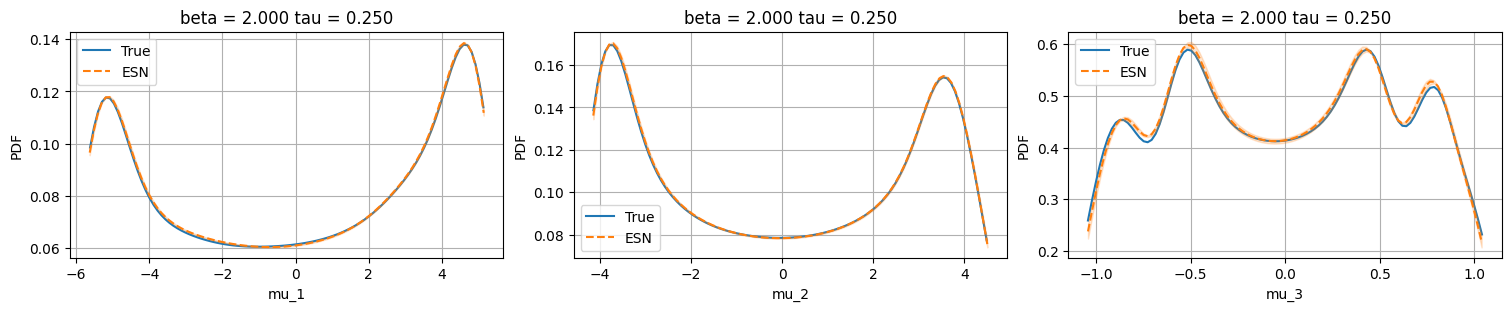

In [44]:
p_sim = {"beta":2.0, 
         "tau":0.25}

regime_str = ' '.join([f"{param_name} = {p_sim[param_name]:0.3f}" for param_name in p_sim.keys()])

# to compute statistics, we evolve the original system and ESN for long time
# so that the statistics converge
loop_times = [100] # 50 periods
sim_time = transient_time+np.sum(loop_times)+washout_time*len(loop_times)

y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

data = pp.create_dataset(y_sim,t_sim,p_sim,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    loop_times=loop_times,
                    input_vars=input_vars,
                    output_vars=output_vars,
                    param_vars=param_vars,
                    N_g=N_g,
                    u_f_order=u_f_order,
                    noise_level=0.0, # set noise zero for ground truth
                    random_seed=None,
                    tau=p_sim["tau"])

Y_PRED = [None] * n_ensemble

# if want to let ESN run from an arbitrary initial condition 
# instead of using washout data from the test regime
y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
eta_1_init = 1.5
y0[0,0] = eta_1_init
u_washout_auto = np.repeat(y0, [N_washout], axis = 0)

N = len(data["loop_0"]["u"])
N_t_long = N+N_transient
p_long0 = np.zeros((1, data["loop_0"]["p"].shape[1]))
p_long0[0] = data["loop_0"]["p"][0]
p_long = np.repeat(p_long0, [N_t_long], axis=0)

for e_idx, my_ESN_ in enumerate(ESN_list):
    if hasattr(my_ESN,"tau"):
        my_ESN_.tau = p_sim["tau"]
    x_pred, y_pred = my_ESN_.closed_loop_with_washout(U_washout=u_washout_auto, 
                                                        N_t=N_t_long, 
                                                        P_washout=data["loop_0"]["p_washout"],  
                                                        P=p_long)
    y_pred = y_pred[N_transient:]
    Y_PRED[e_idx] = y_pred

plt_idx = [eOutputVar.mu_1,eOutputVar.mu_2,eOutputVar.mu_3]
plt.figure(figsize = (15,3),constrained_layout=True)
for j, k in enumerate(plt_idx):
    plt.subplot(1,len(plt_idx),j+1)
    vis.plot_statistics_ensemble(*[Y_PRED[e][:, k] for e in range(n_ensemble)],
                        y_base=data["loop_0"]["y"][:,k],
                        title=regime_str,
                        ylabel='PDF',
                        xlabel=k.name,
                        linestyle=['-','--'],
                        legend=['True','ESN'],
                        color=["tab:blue","tab:orange"])

# Sensitivity to parameters
We compute the sensitivity of the acoustic energy to the system's parameters heat release strength, beta, and time delay, tau. The sensitivity can be inferred from the trained ESN using the tangent linear, adjoint and finite difference methods. We show the results for all of them. In practice, we prefer the adjoint method over tangent linear due to computational efficiency.

In [41]:
methods = ["tangent linear","adjoint","finite difference"] # select computation method

p_sim = {"beta":2.0, 
         "tau":0.25}

loop_times = [100]
sim_time = transient_time+np.sum(loop_times)+washout_time*len(loop_times)

# first we generate the direct solution for sensitivity
y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)
y_bar, t_bar = pp.discard_transient(y_sim,t_sim,transient_time+washout_time)

data = pp.create_dataset(y_sim,t_sim,p_sim,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    loop_times=loop_times,
                    input_vars=input_vars,
                    output_vars=output_vars,
                    param_vars=param_vars,
                    N_g=N_g,
                    u_f_order=u_f_order,
                    noise_level=0.0, # set noise zero for ground truth
                    random_seed=None,
                    tau=p_sim["tau"])

# generate rijke object 
my_rijke = Rijke(
        N_g=N_g,
        N_c=10,
        c_1=0.1,
        c_2=0.06,
        beta=p_sim["beta"],
        x_f=0.2,
        tau=p_sim["tau"],
        heat_law="kings_poly",
        damping="modal",
    )

# calculate sensitivity of the true system
if "tangent linear" in methods:
    # using tangent linear method
    dJdp_dir = sens.true_direct_sensitivity(my_rijke, t_bar, y_bar)

if "adjoint" in methods:
    # using adjoint method
    dJdp_adj = sens.true_adjoint_sensitivity(my_rijke, t_bar, y_bar)

if "finite difference" in methods:
    # using finite differences
    dJdp_finite = sens.true_finite_difference_sensitivity(
        my_rijke, t_bar, y_bar, h=1e-5, h_tau = network_dt, method="central")

# if want to let ESN run from an arbitrary initial condition 
# instead of using washout data from the test regime
y0 = np.zeros((1,DATA["train"]["u_washout"][0].shape[1]))
eta_1_init = 1.5
y0[0,0] = eta_1_init
u_washout_auto = np.repeat(y0, [N_washout], axis = 0)

N = len(data["loop_0"]["u"])
N_t_long = N+N_transient

p_long0 = np.zeros((1, data["loop_0"]["p"].shape[1]))
p_long0[0] = data["loop_0"]["p"][0]
p_long = np.repeat(p_long0, [N_t_long], axis=0)

if hasattr(my_ESN,"tau"):
    my_ESN.tau = p_sim["tau"]
    
# first we generate the direct solution for sensitivity
# run ESN in closed-loop to get a trajectory
x_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=u_washout_auto, 
                                                    N_t=N_t_long, 
                                                    P_washout=data["loop_0"]["p_washout"],  
                                                    P=p_long)
# remove transient
x_tau = x_pred[N_transient - my_ESN.N_tau - 1 : N_transient, : ] # delayed reservoir state, we need it for tau sensitivity
x_tau_fin = x_pred[N_transient - my_ESN.N_tau - 2 : N_transient, : ] # in finite difference method we perturb from left and right N_tau-1/+1
x_pred = x_pred[N_transient:, :]
y_pred = y_pred[N_transient:, :]

# calculate sensitivity of the ESN
if "tangent linear" in methods:
    # using tangent linear method
    dJdp_esn_dir = my_ESN.direct_sensitivity(x_pred, y_pred, N, x_tau, fast_jac=True)

if "adjoint" in methods:
    # using adjoint method
    dJdp_esn_adj = my_ESN.adjoint_sensitivity(x_pred, y_pred, N, x_tau, fast_jac=True)

if "finite difference" in methods:
    # using finite differences                  
    dJdp_esn_finite = my_ESN.finite_difference_sensitivity(X=x_pred, 
                                                        Y=y_pred,  
                                                        P=p_long[N_transient - my_ESN.N_tau - 1 :], 
                                                        N=N, 
                                                        X_tau = x_tau_fin,
                                                        method="central",
                                                        )

for param in eParam:
    if "tangent linear" in methods:
        print_str_dir = f'Tangent linear dJ/d{param.name} true: {dJdp_dir[param]}'
        print_str_dir = print_str_dir + f', dJ/d{param.name} esn: {dJdp_esn_dir[param]}'
        print(print_str_dir)

    if "adjoint" in methods:
        print_str_adj = f'Adjoint dJ/d{param.name} true: {dJdp_adj[param]}'
        print_str_adj = print_str_adj + f', dJ/d{param.name} esn: {dJdp_esn_adj[param]}'
        print(print_str_adj)

    if "finite difference" in methods:
        print_str_fin = f'Finite difference dJ/d{param.name} true: {dJdp_finite[param]}'
        print_str_fin = print_str_fin + f', dJ/d{param.name} esn: {dJdp_esn_finite[param]}'
        print(print_str_fin) 

Tangent linear dJ/dbeta true: 7.858881464643096, dJ/dbeta esn: 7.484016291929521
Adjoint dJ/dbeta true: 7.858881909672934, dJ/dbeta esn: 7.484016291929505
Finite difference dJ/dbeta true: 7.850407478393605, dJ/dbeta esn: 7.483438064870284
Tangent linear dJ/dtau true: 53.03954814587219, dJ/dtau esn: 52.511768044294236
Adjoint dJ/dtau true: 53.039783764444906, dJ/dtau esn: 52.51176804429144
Finite difference dJ/dtau true: 52.876713019086985, dJ/dtau esn: 52.43185991195087


# Sensitivity to initial conditions
We compute the sensitivity of the acoustic energy to the system's initial conditions. In this case, the number of parameters is equal to the reservoir size, so adjoint method is much faster.

In [25]:
methods = ["tangent linear","adjoint","finite difference"] # select computation method

p_sim = {"beta":2.0, 
         "tau":0.25}

loop_times = [4.0] 
sim_time = transient_time+np.sum(loop_times)+washout_time*len(loop_times)

# first we generate the direct solution for sensitivity
y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)
y_bar, t_bar = pp.discard_transient(y_sim,t_sim,transient_time+washout_time)

data = pp.create_dataset(y_sim,t_sim,p_sim,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    loop_times=loop_times,
                    input_vars=input_vars,
                    output_vars=output_vars,
                    param_vars=param_vars,
                    N_g=N_g,
                    u_f_order=u_f_order,
                    noise_level=0.0, # set noise zero for ground truth
                    random_seed=None,
                    tau=p_sim["tau"])

# generate rijke object 
my_rijke = Rijke(
        N_g=N_g,
        N_c=10,
        c_1=0.1,
        c_2=0.06,
        beta=p_sim["beta"],
        x_f=0.2,
        tau=p_sim["tau"],
        heat_law="kings_poly",
        damping="modal",
    )

# calculate sensitivity of the true system
if "tangent linear" in methods:
    # using tangent linear method
    dJdu0_dir = sens.true_direct_sensitivity_init(my_rijke, t_bar, y_bar)

if "adjoint" in methods:
    # using adjoint method
    dJdu0_adj = sens.true_adjoint_sensitivity_init(my_rijke, t_bar, y_bar)

if "finite difference" in methods:
    # using finite differences
    dJdu0_finite = sens.true_finite_difference_sensitivity_init(
        my_rijke, t_bar, y_bar, h=1e-5, method="central")

N = len(data["loop_0"]["u"])

if hasattr(my_ESN,"tau"):
    my_ESN.tau = p_sim["tau"]
W_out_inv = np.linalg.pinv(my_ESN.W_out)

# first we generate the direct solution for sensitivity
# run ESN in open-loop to do washout and get past information
# for the initial condition sensitivity to match ground truth solution
# we need the ESN to synchronize with the true system so that they have the same initial condition
x0_washout = np.zeros(my_ESN.N_reservoir)
x_past = my_ESN.open_loop(
                    x0=x0_washout,
                    U=data["loop_0"]["u_washout"],
                    P=data["loop_0"]["p_washout"],
                )
x_tau = x_past[- my_ESN.N_tau - 1 :, : ]

p = data["loop_0"]["p"][0] * np.ones((N + my_ESN.N_tau + 1, 1)) # we do this because p doesn't change, otherwise need to concatenate with washout p
x_pred, y_pred = my_ESN.closed_loop(x_tau, 
                                    N_t=N,
                                    P=p)


# calculate sensitivity of the ESN
if "tangent linear" in methods:
    # using tangent linear method
    dJdx0_esn_dir = my_ESN.direct_sensitivity_x0(x_pred, y_pred, N, fast_jac=True)
    dJdu0_esn_dir = np.dot(dJdx0_esn_dir, W_out_inv.T)

if "adjoint" in methods:
    # using adjoint method
    dJdx0_esn_adj = my_ESN.adjoint_sensitivity_x0(x_pred, y_pred, N, fast_jac=True)
    dJdu0_esn_adj = np.dot(dJdx0_esn_adj, W_out_inv.T)

if "finite difference" in methods:
    # using finite differences                  
    dJdx0_esn_finite = my_ESN.finite_difference_sensitivity_x0(X=x_pred, 
                                                        Y=y_pred,  
                                                        P=p, 
                                                        N=N, 
                                                        X_tau = x_tau,
                                                        method="central",
                                                        )
    dJdu0_esn_finite = np.dot(dJdx0_esn_finite, W_out_inv.T)

for state_var in [eOutputVar.mu_1, eOutputVar.eta_1]:
    if "tangent linear" in methods:
        print_str_dir = f'Tangent linear dJ/d{state_var.name}(0) true: {dJdu0_dir[state_var]}'
        print_str_dir = print_str_dir + f', dJ/d{state_var.name}(0) esn: {dJdu0_esn_dir[state_var]}'
        print(print_str_dir)

    if "adjoint" in methods:
        print_str_adj = f'Adjoint dJ/d{state_var.name}(0) true: {dJdu0_adj[state_var]}'
        print_str_adj = print_str_adj + f', dJ/d{state_var.name}(0) esn: {dJdu0_esn_adj[state_var]}'
        print(print_str_adj)

    if "finite difference" in methods:
        print_str_fin = f'Finite difference dJ/d{state_var.name}(0) true: {dJdu0_finite[state_var]}'
        print_str_fin = print_str_fin + f', dJ/d{state_var.name}(0) esn: {dJdu0_esn_finite[state_var]}'
        print(print_str_fin)

Tangent linear dJ/dmu_1(0) true: -0.3105132064710331, dJ/dmu_1(0) esn: -0.30723555621532633
Adjoint dJ/dmu_1(0) true: -0.3105140248475894, dJ/dmu_1(0) esn: -0.3072355562153323
Finite difference dJ/dmu_1(0) true: -0.3113075306870883, dJ/dmu_1(0) esn: -0.30723555594119434
Tangent linear dJ/deta_1(0) true: -2.0420817033546603, dJ/deta_1(0) esn: -2.0712497471709352
Adjoint dJ/deta_1(0) true: -2.042081400689279, dJ/deta_1(0) esn: -2.0712497471709375
Finite difference dJ/deta_1(0) true: -2.029951176307776, dJ/deta_1(0) esn: -2.071249747602602


# Loading config files and results
When running the scripts in the src folder, the results are saved in a local folder. Saved config files and hyperparameter search results can be loaded later.

In [48]:
model_dir = "results/rijke"
run_name = "20231029_153121"
model_path = Path(model_dir) / f"run_{run_name}"
config = post.load_config(model_path)
results = pp.unpickle_file(model_path / "results.pickle")[0]